Training Started (Exact Spike Time, Analytical Gradient)...
Epoch 0: Loss 77.70
Epoch 100: Loss 55.18
Epoch 200: Loss 47.73
Epoch 300: Loss 51.73
Epoch 400: Loss 46.34
Epoch 500: Loss 41.76
Epoch 600: Loss 61.60
Epoch 700: Loss 55.49
Epoch 800: Loss 54.96
Epoch 900: Loss 94.46


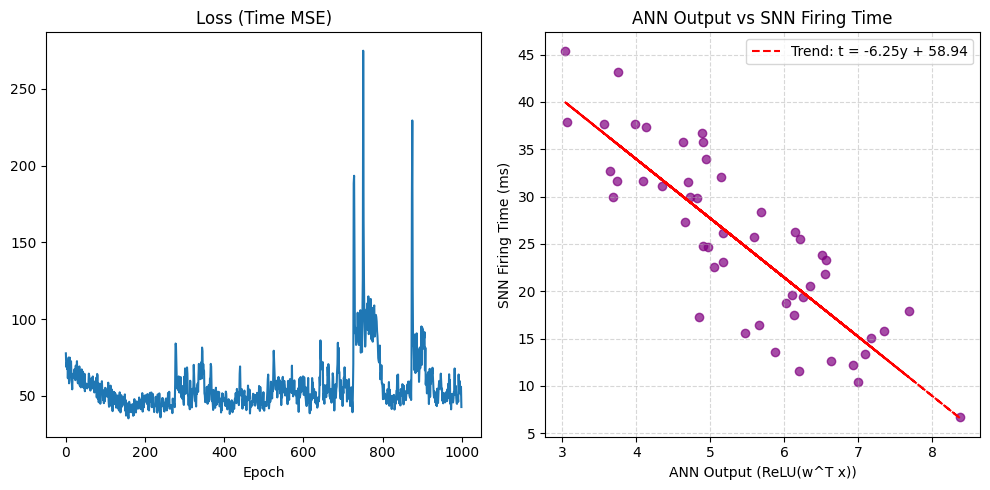

Target Trend (Ideal): Negative Slope (Higher ANN val -> Lower SNN time)
Result Trend Slope : -6.2505 (Should be negative)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# --- 설정 ---
torch.manual_seed(42)
torch.set_default_device('cuda' if torch.cuda.is_available() else 'cpu')

# 물리 상수
TAU_S = 2.0    # Rise time
TAU_M = 20.0   # Decay time
V_TH = 1.0     # 발화 임계값

# 시뮬레이션 설정 (정확도를 위해 dt를 촘촘하게 설정)
DT = 0.1
TIME_WINDOW = 100.0
time_axis = torch.arange(0, TIME_WINDOW, DT)

# 정규화 상수 (Peak를 1로 맞춤)
t_peak = (TAU_M * TAU_S) / (TAU_M - TAU_S) * np.log(TAU_M / TAU_S)
norm_factor = 1.0 / (np.exp(-t_peak / TAU_M) - np.exp(-t_peak / TAU_S))

# --- 1. Custom Autograd Function (핵심: Soft Crossing 제거) ---
class ExactSpikeTime(torch.autograd.Function):
    @staticmethod
    def forward(ctx, weights, delays, input_times):
        """
        순전파: 막전위를 스캔하여 임계값을 넘는 '정확한 첫 시점'을 찾음
        """
        ctx.save_for_backward(weights, delays, input_times)
        
        batch_size = input_times.shape[0]
        output_times = torch.zeros(batch_size, device=weights.device)
        
        # 시뮬레이션 루프 (벡터화)
        # t_grid: (1, 1, Time)
        t_grid = time_axis.view(1, 1, -1).to(weights.device)
        
        # Effective Arrival: (Batch, Inputs, 1)
        arrival = (input_times + delays).unsqueeze(2)
        
        # Double Exp Kernel Calculation
        delta = t_grid - arrival
        mask = (delta > 0).float()
        
        # Kernel: Norm * (exp(-t/tm) - exp(-t/ts))
        k_val = norm_factor * (torch.exp(-delta/TAU_M) - torch.exp(-delta/TAU_S)) * mask
        
        # Membrane Potential: V(t) = Sum(w * k(t))
        # weights: (Inputs) -> (1, Inputs, 1)
        w_expanded = weights.view(1, -1, 1)
        v_mem = torch.sum(w_expanded * k_val, dim=1) # (Batch, Time)
        
        # Find First Crossing
        # argmax는 미분 불가능하지만 forward 값 자체는 정확함
        cross_mask = (v_mem >= V_TH)
        has_fired = cross_mask.any(dim=1)
        
        # 발화한 경우 첫 인덱스 찾기
        first_indices = cross_mask.float().argmax(dim=1)
        fired_times = time_axis[first_indices].to(weights.device)
        
        # 발화하지 않은 경우 패널티 (Max Time)
        final_times = torch.where(has_fired, fired_times, torch.tensor(TIME_WINDOW, device=weights.device))
        
        ctx.indices = first_indices
        ctx.has_fired = has_fired
        ctx.v_mem = v_mem # 디버깅/시각화용
        
        return final_times

    @staticmethod
    def backward(ctx, grad_output):
        """
        역전파: Implicit Function Theorem 사용 (SpikeProp)
        dt/dw = - (dV/dw) / (dV/dt)
        """
        weights, delays, input_times = ctx.saved_tensors
        indices = ctx.indices
        has_fired = ctx.has_fired
        
        batch_size = input_times.shape[0]
        grad_weights = torch.zeros_like(weights)
        grad_delays = torch.zeros_like(delays)
        # input_times에 대한 gradient는 필요하면 추가 (여기선 weights, delays만 학습)
        grad_inputs = None 

        # 발화한 샘플에 대해서만 그라디언트 계산
        fired_batch_indices = torch.where(has_fired)[0]
        
        if len(fired_batch_indices) == 0:
            return torch.zeros_like(weights), torch.zeros_like(delays), None

        # -----------------------------------------------------------
        # Analytical Gradient Calculation
        # -----------------------------------------------------------
        for b in fired_batch_indices:
            idx = indices[b]
            t_spike = time_axis[idx].item()
            grad_out = grad_output[b] # dL/dt
            
            # 1. 분모: 막전위의 시간 기울기 (Slope at firing time)
            # dV/dt = Sum(w * dK/dt)
            # dK/dt = Norm * (-1/tm * exp... - (-1/ts * exp...))
            
            # 해당 배치의 입력 도착 시간들
            arr_times = input_times[b] + delays
            delta = t_spike - arr_times
            
            # Causality Check
            valid_mask = (delta > 0).float()
            
            # 커널 미분값 (dK/dt)
            exp_m = torch.exp(-delta/TAU_M)
            exp_s = torch.exp(-delta/TAU_S)
            dk_dt = norm_factor * ((-1/TAU_M)*exp_m - (-1/TAU_S)*exp_s) * valid_mask
            
            slope = torch.sum(weights * dk_dt)
            
            # 분모가 0에 가까우면 폭주하므로 클리핑
            if torch.abs(slope) < 1e-4:
                slope = 1e-4
            
            factor = -1.0 / slope 
            
            # 2. 분자 및 최종 Gradient
            
            # Weights Gradient: dt/dw = factor * (dV/dw) = factor * K(t)
            k_val_at_t = norm_factor * (exp_m - exp_s) * valid_mask
            grad_w_local = grad_out * factor * k_val_at_t
            grad_weights += grad_w_local # 배치 누적
            
            # Delays Gradient: dt/dd = factor * (dV/dd) 
            # dV/dd = w * dK/dd = w * (dK/dt * -1) = -w * dK/dt
            # 따라서 dt/dd = factor * (-w * dK/dt)
            grad_d_local = grad_out * factor * (-weights * dk_dt)
            grad_delays += grad_d_local # 배치 누적

        # 배치 평균
        return grad_weights / batch_size, grad_delays / batch_size, None

# --- 2. SNN 모델 ---
class PureSNN(nn.Module):
    def __init__(self, num_inputs):
        super().__init__()
        # 가중치 (양수 제약 없음, 자유롭게 학습)
        self.weights = nn.Parameter(torch.rand(num_inputs) * 2.0)
        # 딜레이
        self.delays = nn.Parameter(torch.rand(num_inputs) * 20.0)

    def forward(self, input_vals):
        # Input Latency Encoding: (1 - x) -> 0 ~ 50ms
        # 값이 1.0이면 0ms(빠름), 0.0이면 50ms(느림)
        input_times = (1.0 - input_vals) * 50.0
        
        # Custom Function 호출
        return ExactSpikeTime.apply(self.weights, self.delays, input_times)

# --- 3. 데이터 및 학습 설정 ---
NUM_INPUTS = 10 + 1
model = PureSNN(NUM_INPUTS)
optimizer = optim.Adam(model.parameters(), lr=0.05) # 학습률 조금 높임

# ANN Target (Ground Truth)
true_weights = torch.rand(NUM_INPUTS) * 2.0
def get_ann_output(x):
    # y = ReLU(w^T x)
    return torch.relu(torch.matmul(x, true_weights))

print("Training Started (Exact Spike Time, Analytical Gradient)...")
losses = []

# --- 4. 학습 루프 ---
for epoch in range(1000):
    inputs = torch.rand(256, NUM_INPUTS)
    # 바이어스 입력 고정
    inputs[:, -1] = 1
    
    # 1. ANN 출력 (Target Value)
    ann_out = get_ann_output(inputs)
    
    # 2. Target Time 변환 (Loss 계산용)
    # ANN 값이 클수록 -> 빨리 발화해야 함 (Linear Latency)
    # Range Matching: ANN값 0~10 -> 시간 60ms ~ 20ms
    # t_target = 60 - 4 * ann_out (예시 선형 변환)
    # 이 변환은 학습 대상이 아니라 "우리가 원하는 동작"을 정의하는 레이블입니다.
    target_time = 80.0 - (ann_out * 10.0) 
    # 너무 빠르거나 느리지 않게 클램핑
    target_time = torch.clamp(target_time, min=10.0, max=90.0)
    
    # 3. SNN Forward
    pred_time = model(inputs)
    
    # 4. Loss (시간 차이 MSE)
    # 발화하지 못한 경우(100ms)는 오차가 커서 자동으로 학습됨
    loss = torch.mean((pred_time - target_time) ** 2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Delay 제약 (음수 불가)
    with torch.no_grad():
        model.delays.clamp_(min=0.0)
        
    losses.append(loss.item())
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.2f}")

# --- 5. 결과 시각화 ---
model.eval()
test_in = torch.rand(50, NUM_INPUTS)
ann_y = get_ann_output(test_in).detach()
snn_t = model(test_in).detach()

plt.figure(figsize=(10, 5))

# 1. 학습 곡선
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Loss (Time MSE)")
plt.xlabel("Epoch")

# 2. ANN Output vs SNN Time (핵심 결과)
plt.subplot(1, 2, 2)
plt.scatter(ann_y.cpu(), snn_t.cpu(), alpha=0.7, c='purple')
plt.title("ANN Output vs SNN Firing Time")
plt.xlabel("ANN Output (ReLU(w^T x))")
plt.ylabel("SNN Firing Time (ms)")
plt.grid(True, linestyle='--', alpha=0.5)

# 선형성 확인을 위한 추세선 (단순 시각화용)
m, b = np.polyfit(ann_y.cpu().numpy(), snn_t.cpu().numpy(), 1)
plt.plot(ann_y.cpu(), m*ann_y.cpu() + b, 'r--', label=f'Trend: t = {m:.2f}y + {b:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Target Trend (Ideal): Negative Slope (Higher ANN val -> Lower SNN time)")
print(f"Result Trend Slope : {m:.4f} (Should be negative)")